In [1]:
import numpy as np
import cv2 as cv
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
GRID_H = 9
GRID_W = 6

In [3]:
def project_points(object_points, rvec, tvec, camera_matrix):
    R, _ = cv2.Rodrigues(rvec)  # Convert rvec to rotation matrix

    # Correct homogeneous transformation matrix
    Rt = np.hstack([R, tvec.reshape(3, 1)])  # 3×4 matrix

    P = camera_matrix @ Rt[:3, :]  # 3×4 projection matrix

    # Convert object points to homogeneous coordinates
    object_points_h = np.hstack([object_points, np.ones((object_points.shape[0], 1))])

    # Perform projection
    proj_h = (P @ object_points_h.T).T  # Project points
    proj_2d = proj_h[:, :2] / proj_h[:, 2:]  # Normalize by z

    return proj_2d

In [4]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype("int32"))
    imgpts = imgpts.astype("int32")
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255, 0, 0), 50)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0, 255, 0), 50)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0, 0, 255), 50)
    return img

In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((GRID_H * GRID_W, 3), np.float32)
objp[:, :2] = np.mgrid[0:GRID_H, 0:GRID_W].T.reshape(-1, 2)
axis = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]])

In [10]:
with open("cameraCal.npy", "rb") as f:
    mtx = np.load(f)
    dist = np.load(f)

Number of object points: (54, 3)
Number of image points: (54, 1, 2)
First few object points: [[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]]
First few corner points: [[[ 329.10464 2282.4722 ]]

 [[ 543.3476  2128.597  ]]

 [[ 741.25903 1991.0018 ]]]


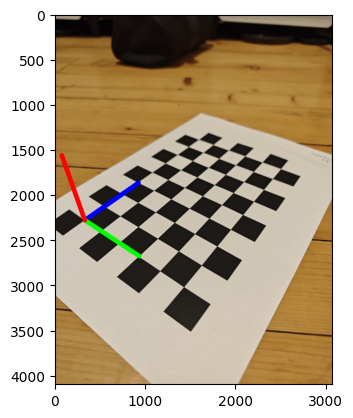

In [17]:
fname = "calibration/IMG_20241218_202731.jpg"
img = cv.imread(fname)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, corners = cv.findChessboardCorners(gray, (GRID_H, GRID_W), None)

if ret == True:
    corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    print("Number of object points:", objp.shape)
    print("Number of image points:", corners2.shape)
    print("First few object points:", objp[:3])
    print("First few corner points:", corners2[:3])

    # Find the rotation and translation vectors.
    ret, rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
    # project 3D points to image plane
    imgpts = project_points(axis, rvecs, tvecs, mtx)

    img = draw(img, corners2, imgpts)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))